### Imports & Utils

In [0]:
!pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-0.1.12-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax
!pip install -q git+https://www.github.com/google/jax-md

In [0]:
import numpy as onp

import jax.numpy as np
from jax import random
from jax import jit
key = random.PRNGKey(0)

from jax_md import space, smap, energy, minimize, quantity, simulate

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

background_color = [0.85, 0.85, 0.9]

def format_plot(x, y):  
  plt.gca().set_axis_bgcolor(background_color)
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Harmonic Minimization

Here we demonstrate some simple example code showing how we might find the inherent structure for some initially random configuration of particles. Note that this code will work on CPU, GPU, or TPU out of the box.

First thing we need to do is set some parameters that define our simulation, including what kind of box we're using (specified using a metric function and a wrapping function).

In [0]:
N = 5000
dimension = 2
box_size = 80.0
displacement, shift = space.periodic(box_size) 

Next we need to generate some random positions as well as particle sizes.

In [0]:
key, split = random.split(key)
R = random.uniform(
    split, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

Then we need to construct our FIRE minimization function.

In [0]:
energy_fn = energy.soft_sphere_pairwise(
    displacement, species=species, sigma=sigma)
fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

Now let's actually do minimization, keepting track of the energy as we go.

In [0]:
E = []
for i in range(200):
  fire_state = fire_apply(fire_state)
  
  E += [energy_fn(fire_state.position)]
R = fire_state.position

Let's plot the nearest distance for different species pairs. We see that particles on average have neighbors that are the right distance apart.

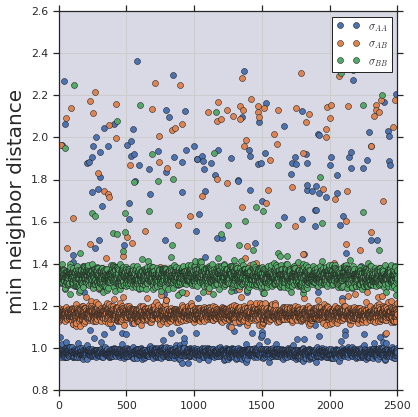

In [0]:
metric = lambda R: space.distance(displacement(R, R))
dr = metric(R)
plt.plot(np.min(dr[:N_2, :N_2] + 5 * np.eye(N_2, N_2), axis=0), 'o', 
         label='$\\sigma_{AA}$')
plt.plot(np.min(dr[:N_2, N_2:] + 5 * np.eye(N_2, N_2), axis=0), 'o',
         label='$\\sigma_{AB}$')
plt.plot(np.min(dr[N_2:, N_2:] + 5 * np.eye(N_2, N_2), axis=0), 'o',
         label='$\\sigma_{BB}$')

plt.legend()
format_plot('', 'min neighbor distance')
finalize_plot()

Now let's plot the system. It's nice and minimized!

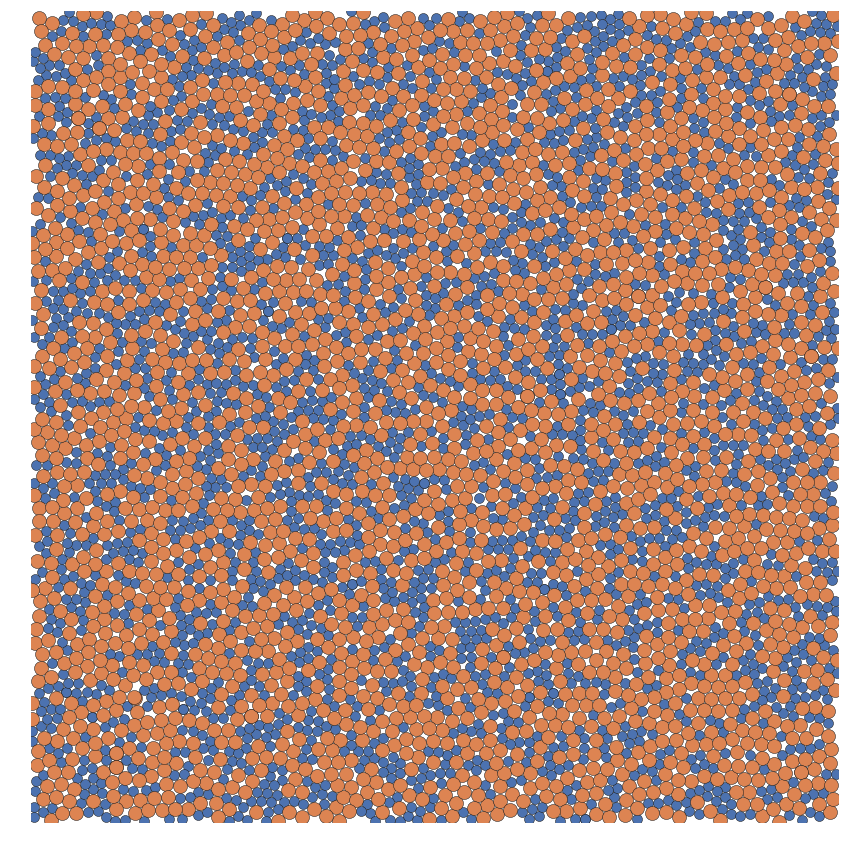

In [0]:
ms = 20
R_plt = onp.array(fire_state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

Finally, let's plot the energy trajectory that we observer during FIRE minimization.

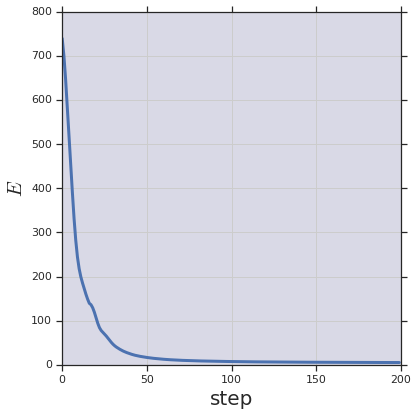

In [0]:
plt.plot(E, linewidth=3)

format_plot('step', '$E$')
finalize_plot()